In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import SVG, HTML
import pygal
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from numpy.random import normal
import math
import usefulFunctions
from usefulFunctions import checkForNull
from random import randrange

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# loading in the data and splitting it up into control vs sick, male vs female as well as by age
control = {}
sick = {}
male = {}
female = {}
young_age = {}    # younger than 50
middle_1_age = {} # between 50 and 60
middle_2_age = {} # between 60 and 65
middle_3_age = {} # between 65 and 70
old_age = {}      # older than 70


age = []
months = []

fileName = "Master_PL.xlsx - Master_PL.csv"
table = pd.read_csv(fileName, header=0, 
                    names=["id", "type", "gender", "age", "monthsFromScreening", "protein_BL", "protein_V4",
                          "protein_V6", "protein_V8", "protein_V10", "protein_V12"])

totalRows = len(table.values)

# splitting data into female vs male, control vs sick, plus storing the age and months data
# into arrays so we can look at their distributions later (to understand good age bands)
for row in table.to_dict(orient='records'):
    if not checkForNull(row['type']):
        if row['type'] == 1:
            control[int(row['id'])] = row
        else:
            sick[int(row['id'])] = row
    
    if not checkForNull(row['gender']):
        if row['gender'] == 1:
            female[int(row['id'])] = row
        else:
            male[int(row['id'])] = row
    
    if not checkForNull(row['age']):
        if row['age']< 50:
            young_age[int(row['id'])] = row
        elif row['age'] < 60:
            middle_1_age[int(row['id'])] = row
        elif row['age'] < 65:
            middle_2_age[int(row['id'])] = row
        elif row['age'] < 70:
            middle_3_age[int(row['id'])] = row
        else:
            old_age[int(row['id'])] = row

    
    if row['age'] is not None:
        age.append(row['age'])
    
    if row['monthsFromScreening'] is not None:
        months.append(row['monthsFromScreening'])

print "Number of data points that are males : " + str(len(male))
print "Number of data points that are females : " + str(len(female))
print "Number of data points that are control : " + str(len(control))
print "Number of data points that are sick : " + str(len(sick))
print "Number of young : " + str(len(young_age))
print "Number of middle_1 : " + str(len(middle_1_age))
print "Number of middle_2 : " + str(len(middle_2_age))
print "Number of middle_3 : " + str(len(middle_3_age))
print "Number of old : " + str(len(old_age))

Number of data points that are males : 403
Number of data points that are females : 216
Number of data points that are control : 196
Number of data points that are sick : 423
Number of young : 78
Number of middle_1 : 168
Number of middle_2 : 118
Number of middle_3 : 119
Number of old : 136


In [3]:
# splitting the data up to look at males who are sick vs control, and females who are sick vs control
tup = usefulFunctions.combine(male, female, control, sick)
maleSplit = tup[0]
femaleSplit = tup[1]
print "Number of Males that are in the Control : " + str(len(maleSplit[0]))
print "Number of Males that are Sick : " + str(len(maleSplit[1]))
print "Number of Females that are in the Control : " + str(len(femaleSplit[0]))
print "Number of Females that are Sick : " + str(len(femaleSplit[1]))

Number of Males that are in the Control : 126
Number of Males that are Sick : 277
Number of Females that are in the Control : 70
Number of Females that are Sick : 146


In [4]:
# splitting the data up to look at young (x<50) people who are males vs females
# splitting the data up to look at middle_1 (50<=x<60) people who are males vs females
# splitting the data up to look at middle_2 (60<=x<65) people who are males vs females
# splitting the data up to look at middle_3 (65<=x<70) people who are males vs females
# splitting the data up to look at old (x>70) people who are males vs females
young_split, middle_1_split = usefulFunctions.combine(young_age, middle_1_age, male, female)
middle_2_split, middle_3_split = usefulFunctions.combine(middle_2_age, middle_3_age, male, female)
old_age_split, blah = usefulFunctions.combine(old_age, young_age, male, female)
print "Number of young males : " + str(len(young_split[0]))
print "Number of young females : " + str(len(young_split[1]))
print "Number of middle_1 males : " + str(len(middle_1_split[0]))
print "Number of middle_1 females : " + str(len(middle_1_split[1]))
print "Number of middle_2 males : " + str(len(middle_2_split[0]))
print "Number of middle_2 females : " + str(len(middle_2_split[1]))
print "Number of middle_3 males : " + str(len(middle_3_split[0]))
print "Number of middle_3 females : " + str(len(middle_3_split[1]))
print "Number of old males : " + str(len(old_age_split[0]))
print "Number of old females : " + str(len(old_age_split[1]))


Number of young males : 49
Number of young females : 29
Number of middle_1 males : 98
Number of middle_1 females : 70
Number of middle_2 males : 76
Number of middle_2 females : 42
Number of middle_3 males : 85
Number of middle_3 females : 34
Number of old males : 95
Number of old females : 41


The following portion of the notebook is looking at whether we can notice diffences between sick vs control patients after filtering the total populations into female and male groups. We also look to see if we can see protein levels cluster together by age within the female and male groups.

In [5]:
# getting only fully filled out entries to plot
proteinKeys = ['protein_BL', 'protein_V4', 'protein_V6', 'protein_V8', 'protein_V10', 'protein_V12']

def getFullValuesOnly(dic, filterOutliers=True):
    fullEntities = {}
    for key in dic:
        entity = dic[key]
        valid = True
        for key2 in proteinKeys:
            if not usefulFunctions.checkForValid(entity[key2]):
                valid = False
            if filterOutliers:
                if entity[key2] >= 100 or entity[key2] <= 10:
                    valid = False
        if valid:
            temp = []
            for key2 in proteinKeys:
                temp.append(entity[key2])
        
            fullEntities[key] = {"age" : entity["age"], 
                                 "monthsFromScreening" : entity["monthsFromScreening"], 
                                 "vector" : temp } 
        
    return fullEntities

controlMales = getFullValuesOnly(maleSplit[0])
sickMales = getFullValuesOnly(maleSplit[1])
controlFemales = getFullValuesOnly(femaleSplit[0])
sickFemales = getFullValuesOnly(femaleSplit[1])

In [6]:
len(controlMales), len(controlFemales)

(18, 13)

In [7]:
len(sickMales), len(sickFemales)

(33, 11)

In [10]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

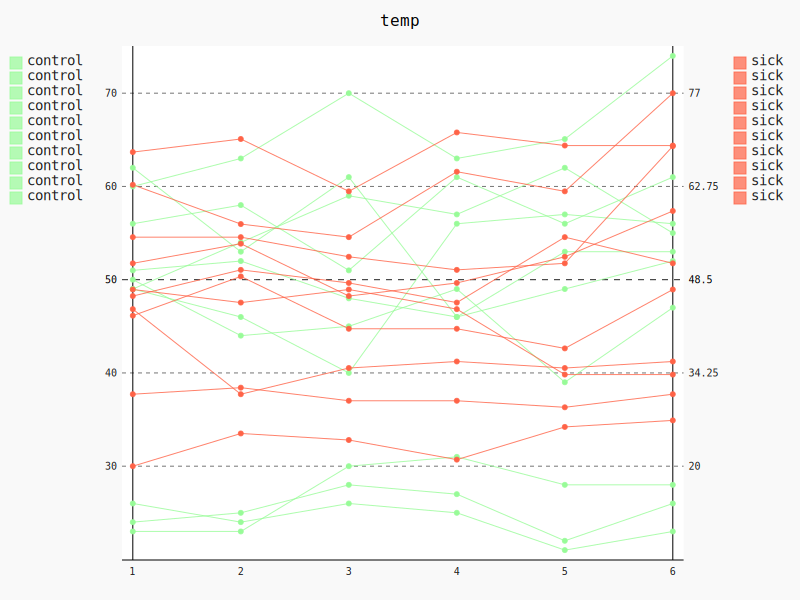

In [40]:
def selectRandom(dic, n):
    random = {}
    keys = dic.keys()
    size = len(keys)
    for i in range(n):
        index = randrange(0, size)
        random[keys[index]] = dic[keys[index]]
        keys[index] = keys[size-1]
        size +=-1  
    return random

# selecting 10 for visual purposes
randomControlMales = selectRandom(controlMales, 10)
randomSickMales = selectRandom(sickMales, 10)
labels = []
allFullyFilledMales = []
colors=[]
for key in randomControlMales:
    labels.append("control")
    colors.append('#98FB98')
    allFullyFilledMales.append(randomControlMales[key]['vector'])
for key in randomSickMales:
    labels.append("sick")
    colors.append('#FF6347')
    allFullyFilledMales.append(randomSickMales[key]['vector'])

# colors = ['go:', 'rs--']
# title = "Male -- Control (green) vs Sick (red) Protein levels over time"
# usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledMales, labels, colors, title)
usefulFunctions.createPyGalLinePlots(allFullyFilledMales, labels, ["1", "2", "3", "4", "5", "6"],colors,"test.svg")
print "open file for intractiveness"

In [31]:
line_chart = pygal.Line()
line_chart.title = 'Browser usage evolution (in %)'
line_chart.x_labels = map(str, range(2002, 2013))
line_chart.add('Firefox', [None, None, 0, 16.6,   25,   31, 36.4, 45.5, 46.3, 42.8, 37.1])
line_chart.add('Chrome',  [None, None, None, None, None, None,    0,  3.9, 10.8, 23.8, 35.3])
line_chart.add('IE',      [85.8, 84.6, 84.7, 74.5,   66, 58.6, 54.7, 44.8, 36.2, 26.6, 20.1])
line_chart.add('Others',  [14.2, 15.4, 15.3,  8.9,    9, 10.4,  8.9,  5.8,  6.7,  6.8,  7.5])
HTML(html_pygal.format(pygal_render=line_chart.render()).decode('utf-8'))

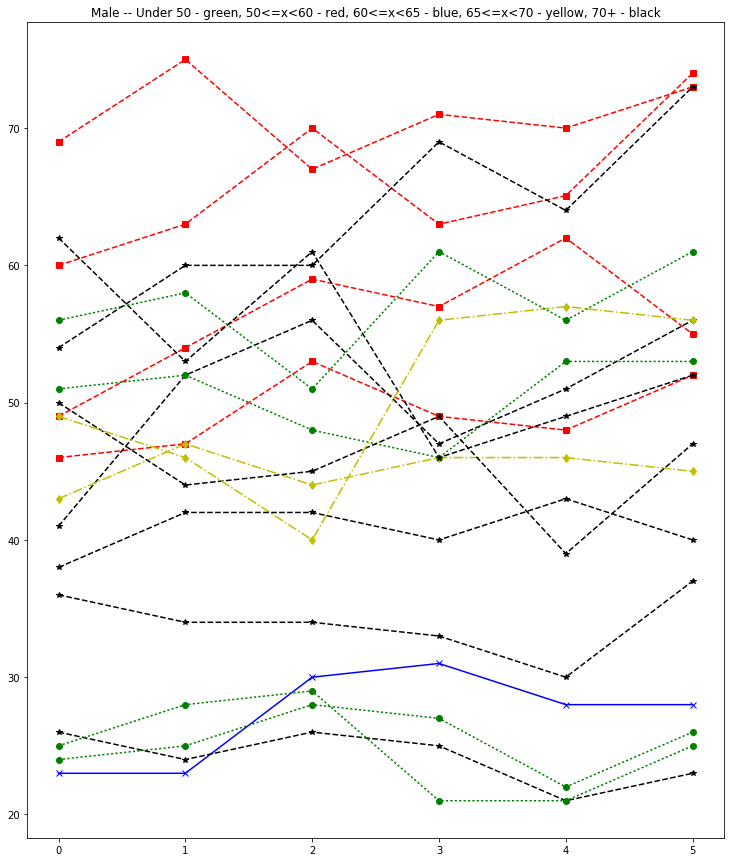

Under 50 - green, 50<=x<60 - red, 60<=x<65 - blue, 65<=x<70 - yellow, 70+ - black


In [11]:
colors = ['go:', 'rs--', 'bx-', 'yd-.', 'k*--']
legend = ['Under 50', '50<=x<60', '60<=x<65', '65<=x<70', '70+']
labels = []
vectors = []
for key in controlMales:
    male = controlMales[key]
    if male['age'] < 50:
        labels.append(0)
    elif male['age'] < 60:
        labels.append(1)
    elif male['age'] < 65:
        labels.append(2)
    elif male['age'] < 70:
        labels.append(3)
    else:
        labels.append(4)
    vectors.append(male['vector'])
title = "Male -- Under 50 - green, 50<=x<60 - red, 60<=x<65 - blue, 65<=x<70 - yellow, 70+ - black"
usefulFunctions.createLinePlotsOnSamePlot(vectors, labels, colors, title)
print "Under 50 - green, 50<=x<60 - red, 60<=x<65 - blue, 65<=x<70 - yellow, 70+ - black"

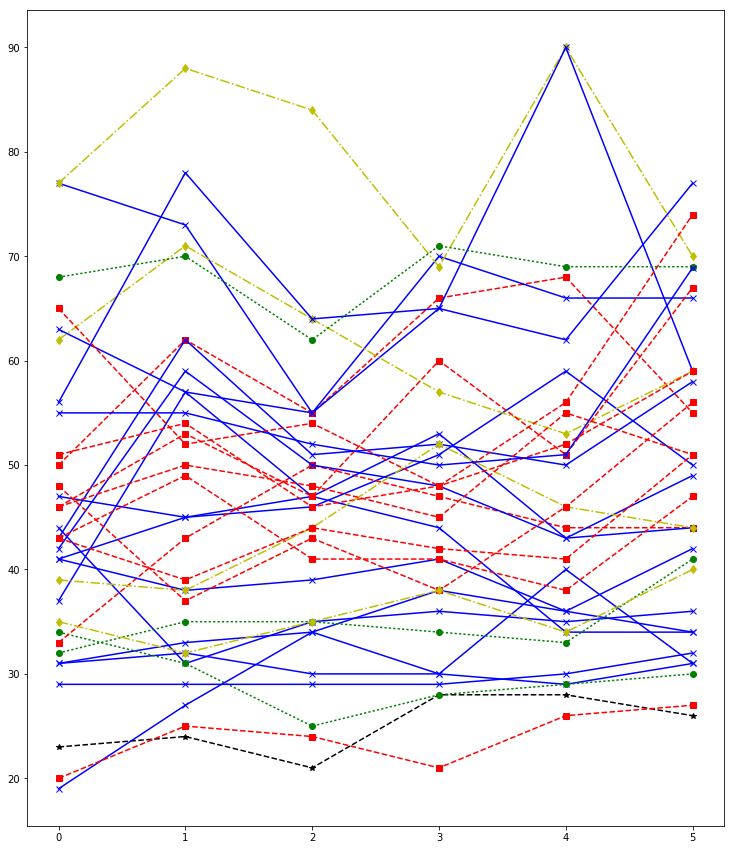

Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black


In [64]:
colors = ['go:', 'rs--', 'bx-', 'yd-.', 'k*--']
legend = ['Under 50', '50<=x<60', '60<=x<70', '70<=x<75', '75+']
labels = []
vectors = []
for key in sickMales:
    male = sickMales[key]
    if male['age'] < 50:
        labels.append(0)
    elif male['age'] < 60:
        labels.append(1)
    elif male['age'] < 70:
        labels.append(2)
    elif male['age'] < 75:
        labels.append(3)
    else:
        labels.append(4)
    vectors.append(male['vector'])
usefulFunctions.createLinePlotsOnSamePlot(vectors, labels, colors)
print "Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black"

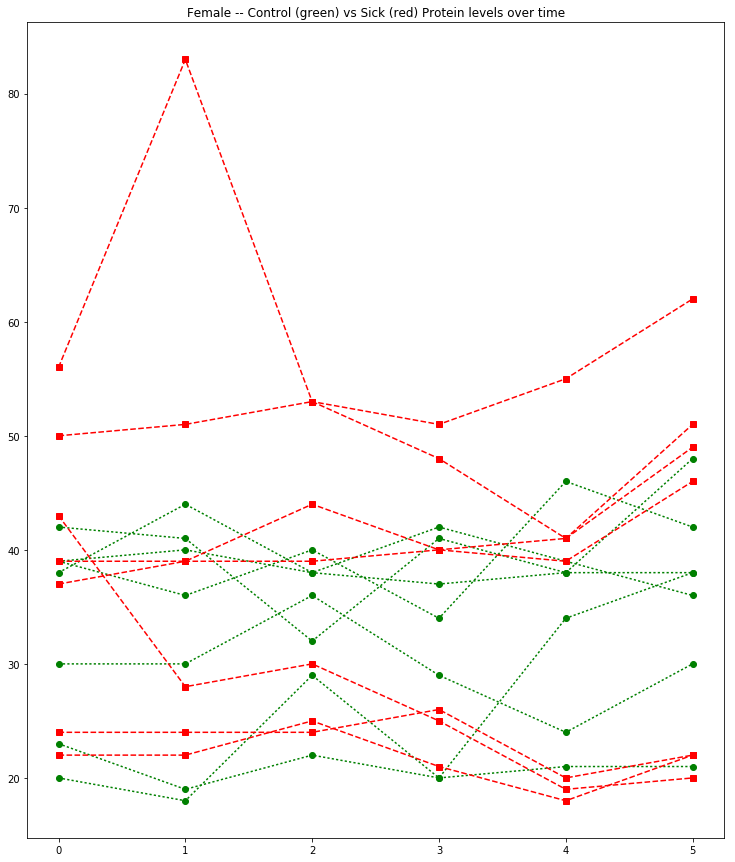

In [16]:
randomControlFemales = []
randomSickFemales = []

randomControlFemales = selectRandom(controlFemales, 7)
randomSickFemales = selectRandom(sickFemales, 7)

labels = []
for entry in randomControlFemales:
    labels.append(0)
for entry in randomSickFemales:
    labels.append(1)

allFullyFilledFemales = randomControlFemales + randomSickFemales
colors = ['go:', 'rs--']
title = "Female -- Control (green) vs Sick (red) Protein levels over time"

usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledFemales, labels, colors, title)

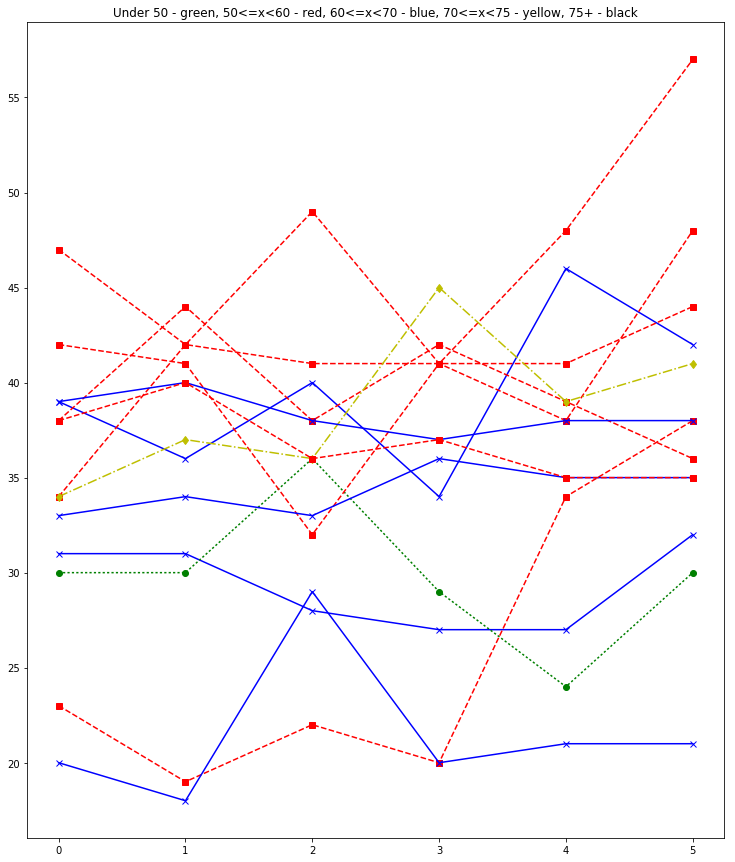

Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black


In [65]:
colors = ['go:', 'rs--', 'bx-', 'yd-.', 'k*--']
legend = ['Under 50', '50<=x<60', '60<=x<70', '70<=x<75', '75+']
labels = []
vectors = []
for key in controlFemales:
    male = controlFemales[key]
    if male['age'] < 50:
        labels.append(0)
    elif male['age'] < 60:
        labels.append(1)
    elif male['age'] < 70:
        labels.append(2)
    elif male['age'] < 75:
        labels.append(3)
    else:
        labels.append(4)
    vectors.append(male['vector'])
title = "Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black"
usefulFunctions.createLinePlotsOnSamePlot(vectors, labels, colors, title)
print "Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black"

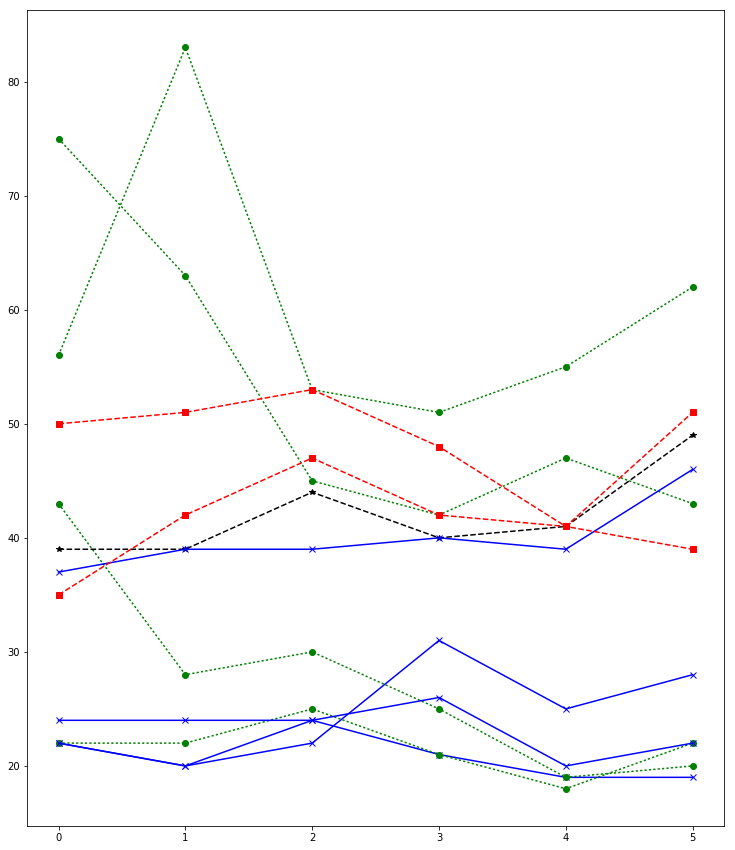

Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black


In [97]:
colors = ['go:', 'rs--', 'bx-', 'yd-.', 'k*--']
legend = ['Under 50', '50<=x<60', '60<=x<70', '70<=x<75', '75+']
labels = []
vectors = []
for key in sickFemales:
    female = sickFemales[key]
    if female['age'] < 50:
        labels.append(0)
    elif female['age'] < 60:
        labels.append(1)
    elif female['age'] < 70:
        labels.append(2)
    elif female['age'] < 75:
        labels.append(3)
    else:
        labels.append(4)
    vectors.append(female['vector'])
usefulFunctions.createLinePlotsOnSamePlot(vectors, labels, colors)
print "Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black"

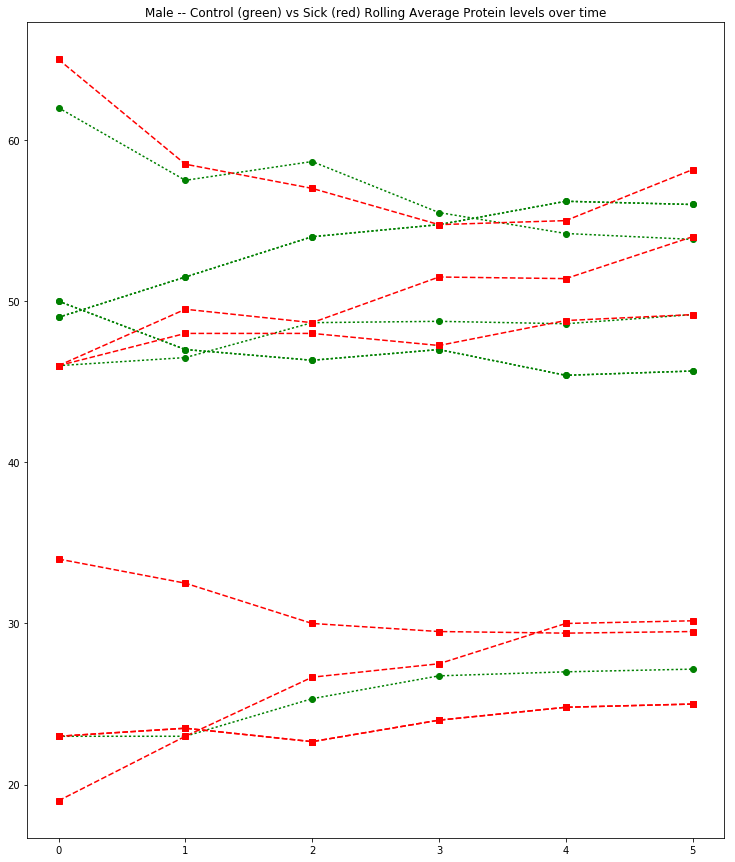

In [91]:
def computeRollingAverages(dic):
    rollingAverageMatrix = {}
    for key in dic:
        row = dic[key]['vector']
        temp = []
        temp.append((row[0], row[0]))
        for j in range(1,len(row)):
            newCount = temp[j-1][1]+row[j]
            temp.append((newCount/float(j+1), newCount))
        temp1 = []
        for j in range(len(temp)):
            temp1.append(temp[j][0])
        rollingAverageMatrix[key] = {'age' : dic[key]['age'],
                                'monthsFromScreening' : dic[key]['monthsFromScreening'],
                                'vector' : temp1}
    return rollingAverageMatrix

rollingAverageControlMales = computeRollingAverages(controlMales)
rollingAverageSickMales = computeRollingAverages(sickMales)

randomAvgControlMales = selectRandom(rollingAverageControlMales, 7)
randomAvgSickMales = selectRandom(rollingAverageSickMales, 7)

labels = []
allFullyFilledAvgMales =  []
for key in randomAvgControlMales:
    labels.append(0)
    allFullyFilledAvgMales.append(randomAvgControlMales[key]['vector'])
for key in randomAvgSickMales:
    labels.append(1)
    allFullyFilledAvgMales.append(randomAvgSickMales[key]['vector'])

colors = ['go:', 'rs--']
title = "Male -- Control (green) vs Sick (red) Rolling Average Protein levels over time"
usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledAvgMales, labels, colors, title)
# green is control
# red is sick       

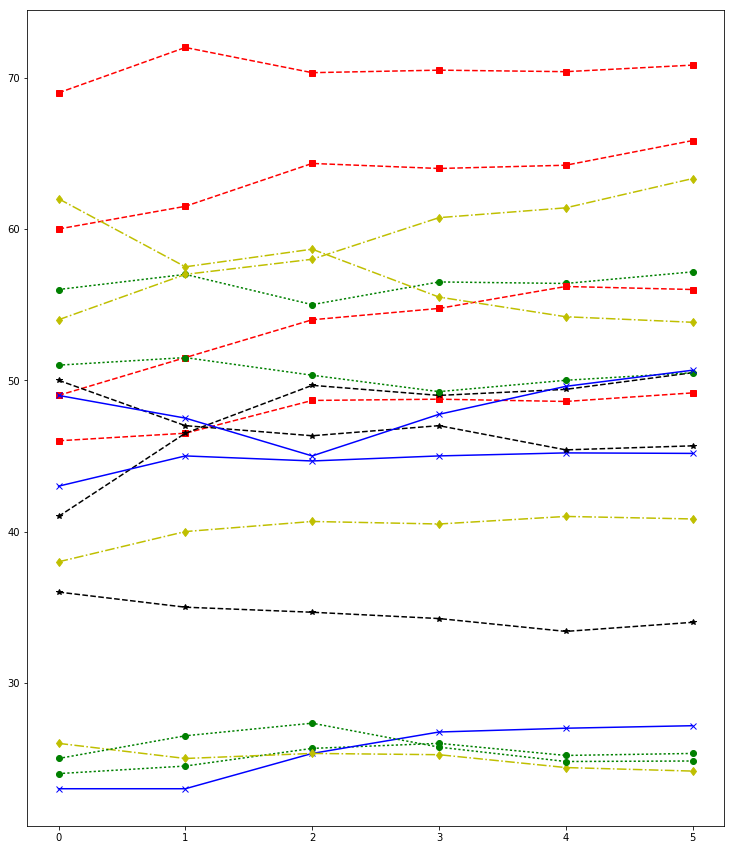

Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black


In [98]:
colors = ['go:', 'rs--', 'bx-', 'yd-.', 'k*--']
legend = ['Under 50', '50<=x<60', '60<=x<70', '70<=x<75', '75+']
labels = []
vectors = []
for key in rollingAverageControlMales:
    male = rollingAverageControlMales[key]
    if male['age'] < 50:
        labels.append(0)
    elif male['age'] < 60:
        labels.append(1)
    elif male['age'] < 70:
        labels.append(2)
    elif male['age'] < 75:
        labels.append(3)
    else:
        labels.append(4)
    vectors.append(male['vector'])
usefulFunctions.createLinePlotsOnSamePlot(vectors, labels, colors)
print "Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black"

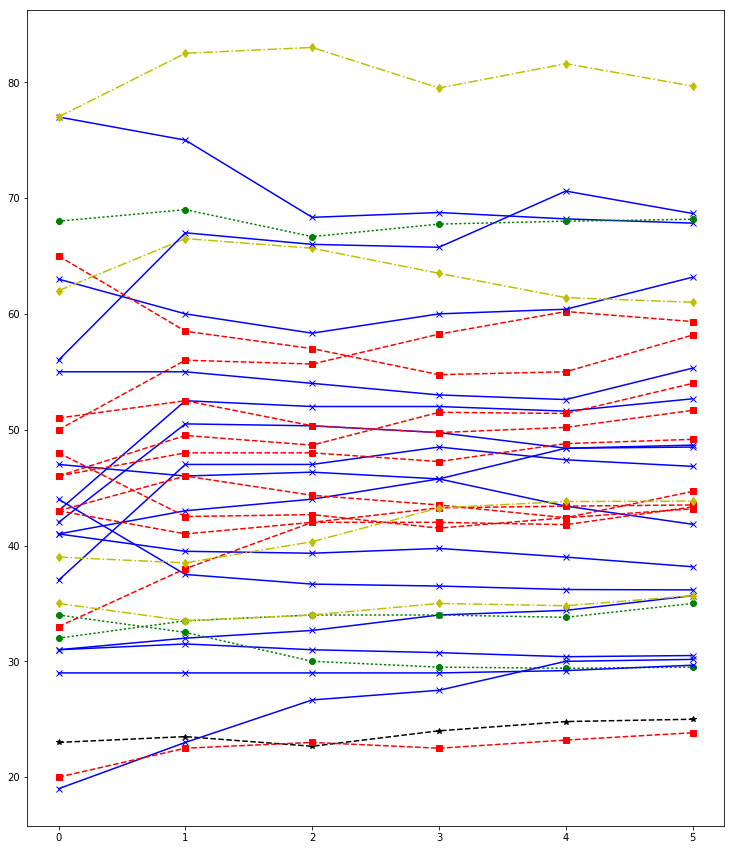

Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black


In [100]:
colors = ['go:', 'rs--', 'bx-', 'yd-.', 'k*--']
legend = ['Under 50', '50<=x<60', '60<=x<70', '70<=x<75', '75+']
labels = []
vectors = []
for key in rollingAverageSickMales:
    male = rollingAverageSickMales[key]
    if male['age'] < 50:
        labels.append(0)
    elif male['age'] < 60:
        labels.append(1)
    elif male['age'] < 70:
        labels.append(2)
    elif male['age'] < 75:
        labels.append(3)
    else:
        labels.append(4)
    vectors.append(male['vector'])
usefulFunctions.createLinePlotsOnSamePlot(vectors, labels, colors)
print "Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black"

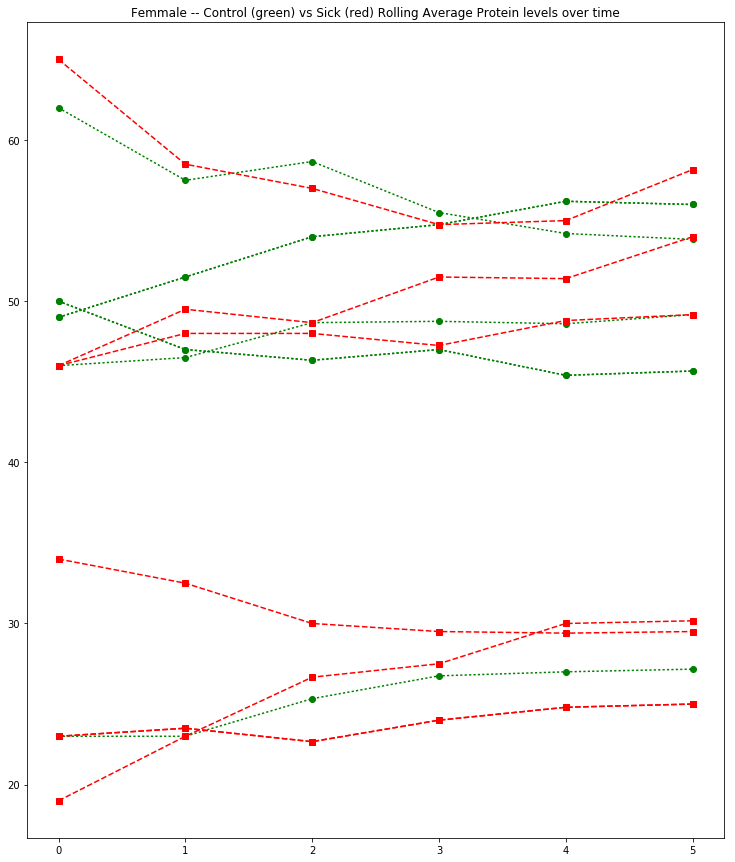

In [101]:
rollingAverageControlFemales = computeRollingAverages(controlFemales)
rollingAverageSickFemales = computeRollingAverages(sickFemales)

randomAvgControlFemales = selectRandom(rollingAverageControlFemales, 7)
randomAvgSickFemales = selectRandom(rollingAverageSickFemales, 7)

labels = []
allFullyFilledAvgFemales =  []
for key in randomAvgControlFemales:
    labels.append(0)
    allFullyFilledAvgFemales.append(randomAvgControlFemales[key]['vector'])
for key in randomAvgSickFemales:
    labels.append(1)
    allFullyFilledAvgFemales.append(randomAvgSickFemales[key]['vector'])

colors = ['go:', 'rs--']
title = "Femmale -- Control (green) vs Sick (red) Rolling Average Protein levels over time"
usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledAvgMales, labels, colors, title)
# green is control
# red is sick       

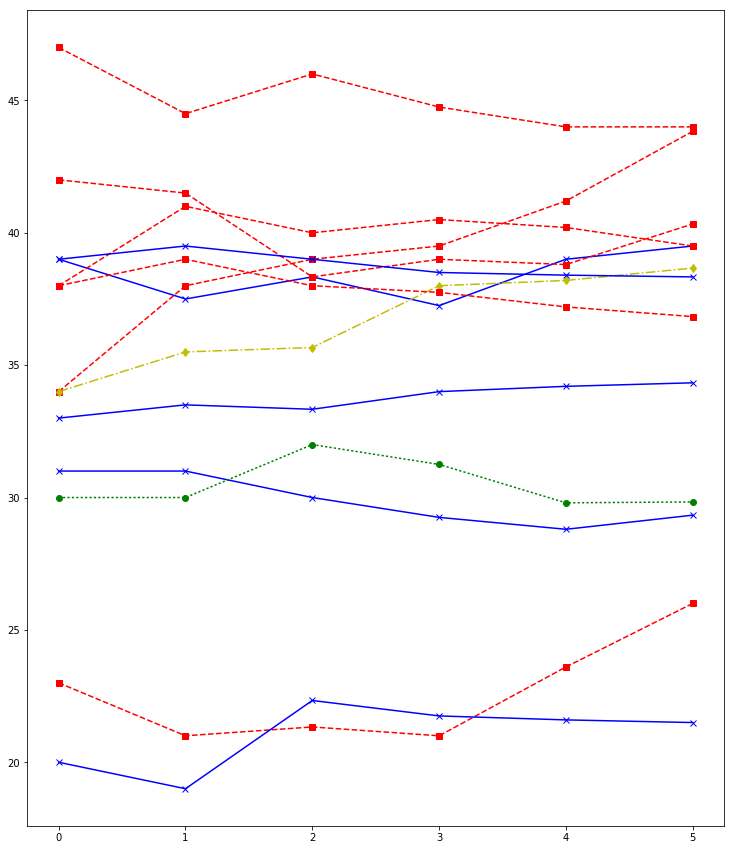

Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black


In [103]:
colors = ['go:', 'rs--', 'bx-', 'yd-.', 'k*--']
legend = ['Under 50', '50<=x<60', '60<=x<70', '70<=x<75', '75+']
labels = []
vectors = []
for key in rollingAverageControlFemales:
    female = rollingAverageControlFemales[key]
    if female['age'] < 50:
        labels.append(0)
    elif female['age'] < 60:
        labels.append(1)
    elif female['age'] < 70:
        labels.append(2)
    elif female['age'] < 75:
        labels.append(3)
    else:
        labels.append(4)
    vectors.append(female['vector'])
usefulFunctions.createLinePlotsOnSamePlot(vectors, labels, colors)
print "Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black"

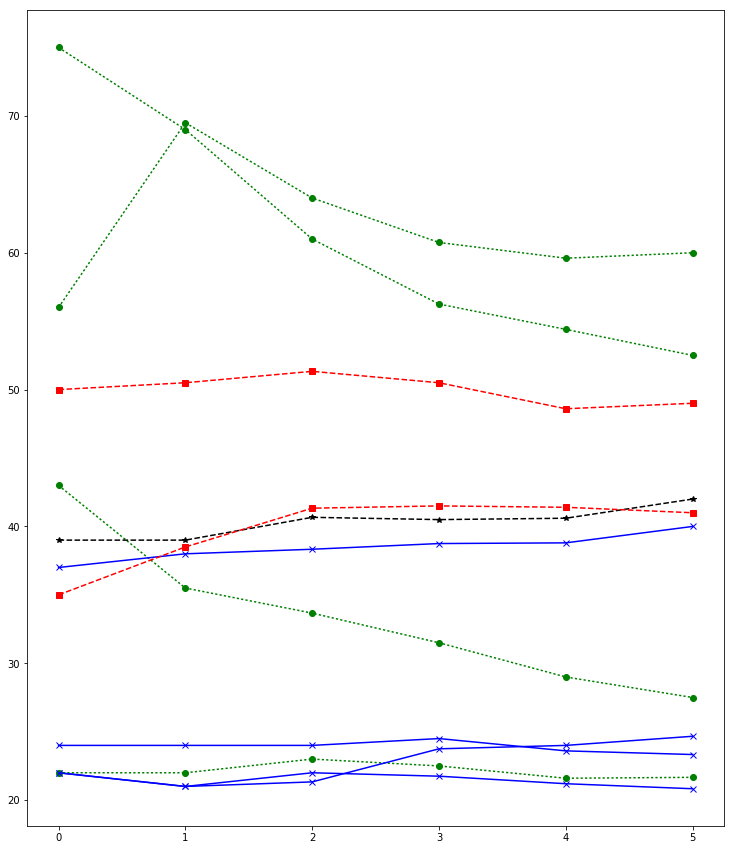

Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black


In [123]:
colors = ['go:', 'rs--', 'bx-', 'yd-.', 'k*--']
legend = ['Under 50', '50<=x<60', '60<=x<70', '70<=x<75', '75+']
labels = []
vectors = []
for key in rollingAverageSickFemales:
    female = rollingAverageSickFemales[key]
    if female['age'] < 50:
        labels.append(0)
    elif female['age'] < 60:
        labels.append(1)
    elif female['age'] < 70:
        labels.append(2)
    elif female['age'] < 75:
        labels.append(3)
    else:
        labels.append(4)
    vectors.append(female['vector'])
usefulFunctions.createLinePlotsOnSamePlot(vectors, labels, colors)
print "Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black"

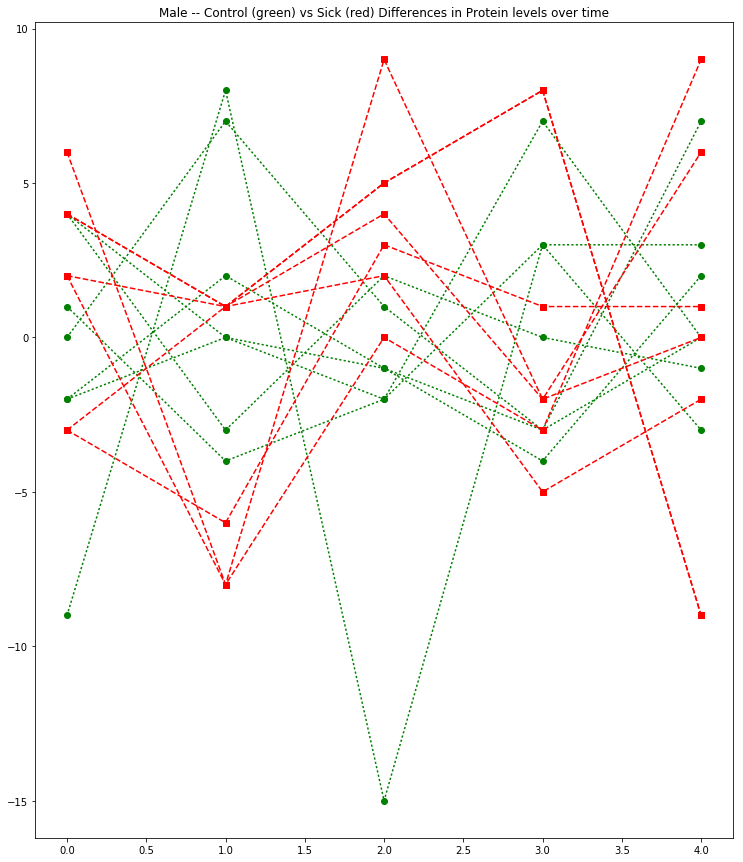

In [111]:
def computeDifferences(dic, absolute = True):
    differenceMatrix = {}
    for key in dic:
        row = dic[key]['vector']
        temp = []
        for j in range(1,len(row)):
            if absolute:
                temp.append(abs(row[j-1]-row[j]))
            else:
                temp.append((row[j]-row[j-1]))
        
        temp2 = []
        for j in range(len(temp)):
            temp2.append(temp[j])
        differenceMatrix[key] = {'age' : dic[key]['age'],
                                'monthsFromScreening' : dic[key]['monthsFromScreening'],
                                'vector' : temp2}
    return differenceMatrix

differenceControlMales = computeDifferences(controlMales, False)
differenceSickMales = computeDifferences(sickMales, False)
randomDiffControlMales = selectRandom(differenceControlMales, 7)
randomDiffSickMales = selectRandom(differenceSickMales, 7)

labels = []
allFullyFilledDiffMales = []
for key in randomDiffControlMales:
    labels.append(0)
    allFullyFilledDiffMales.append(randomDiffControlMales[key]['vector'])
for key in randomDiffSickMales:
    labels.append(1)
    allFullyFilledDiffMales.append(randomDiffSickMales[key]['vector'])

colors = ['go:', 'rs--']
title = "Male -- Control (green) vs Sick (red) Differences in Protein levels over time"

usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledDiffMales, labels, colors, title)
# green is control
# red is sick       

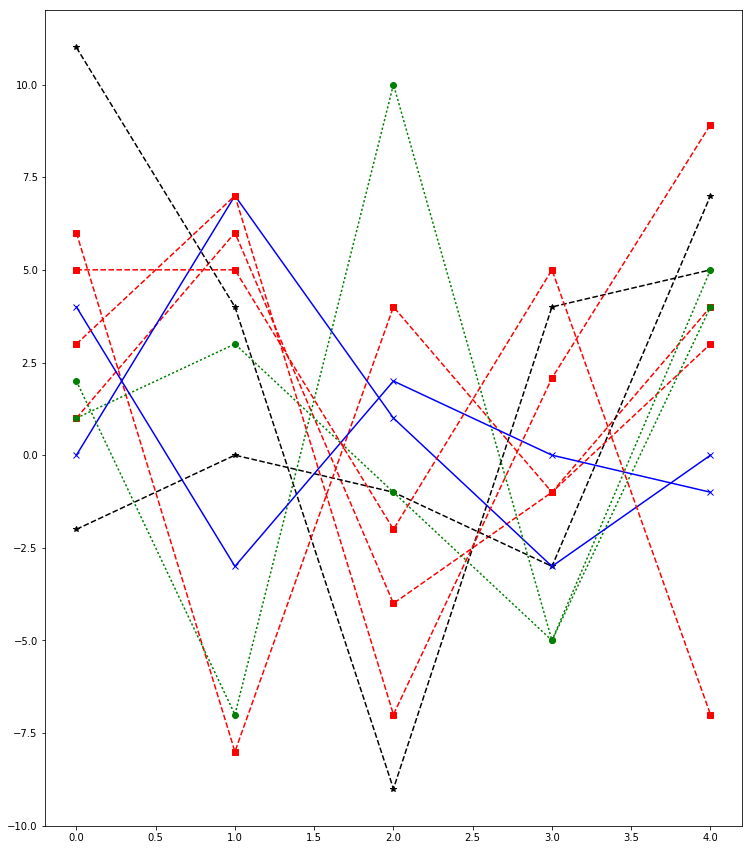

Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black


In [115]:
colors = ['go:', 'rs--', 'bx-', 'yd-.', 'k*--']
legend = ['Under 50', '50<=x<60', '60<=x<70', '70<=x<75', '75+']
labels = []
vectors = []
for key in differenceControlMales.keys()[:10]:
    male = differenceControlMales[key]
    if male['age'] < 50:
        labels.append(0)
    elif male['age'] < 60:
        labels.append(1)
    elif male['age'] < 70:
        labels.append(2)
    elif male['age'] < 75:
        labels.append(3)
    else:
        labels.append(4)
    vectors.append(male['vector'])
usefulFunctions.createLinePlotsOnSamePlot(vectors, labels, colors)
print "Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black"

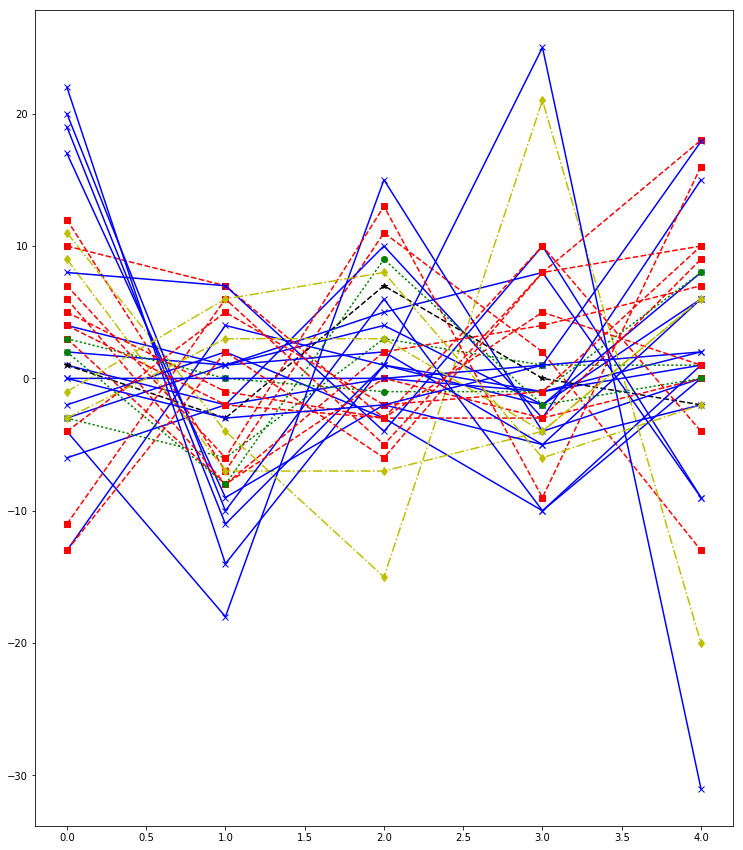

Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black


In [117]:
colors = ['go:', 'rs--', 'bx-', 'yd-.', 'k*--']
legend = ['Under 50', '50<=x<60', '60<=x<70', '70<=x<75', '75+']
labels = []
vectors = []
for key in differenceSickMales.keys():
    male = differenceSickMales[key]
    if male['age'] < 50:
        labels.append(0)
    elif male['age'] < 60:
        labels.append(1)
    elif male['age'] < 70:
        labels.append(2)
    elif male['age'] < 75:
        labels.append(3)
    else:
        labels.append(4)
    vectors.append(male['vector'])
usefulFunctions.createLinePlotsOnSamePlot(vectors, labels, colors)
print "Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black"

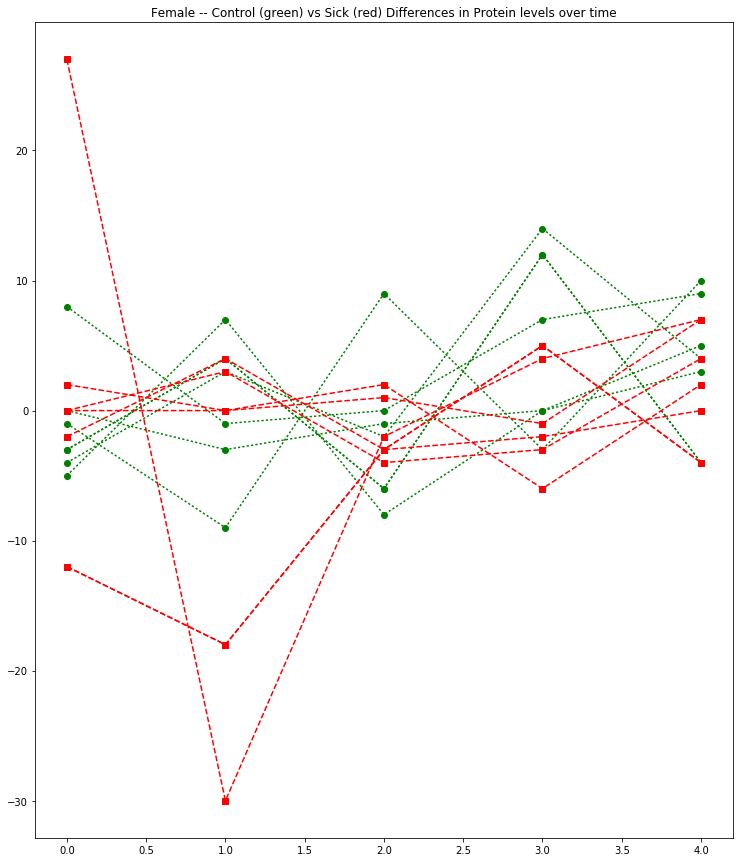

In [120]:
differenceControlFemales = computeDifferences(controlFemales, False)
differenceSickFemales = computeDifferences(sickFemales, False)
randomDiffControlFemales = selectRandom(differenceControlFemales, 7)
randomDiffSickFemales = selectRandom(differenceSickFemales, 7)

labels = []
allFullyFilledDiffFemales = []
for key in randomDiffControlFemales:
    labels.append(0)
    allFullyFilledDiffFemales.append(randomDiffControlFemales[key]['vector'])
for key in randomDiffSickFemales:
    labels.append(1)
    allFullyFilledDiffFemales.append(randomDiffSickFemales[key]['vector'])

colors = ['go:', 'rs--']
title = "Female -- Control (green) vs Sick (red) Differences in Protein levels over time"

usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledDiffFemales, labels, colors, title)
# green is control
# red is sick       

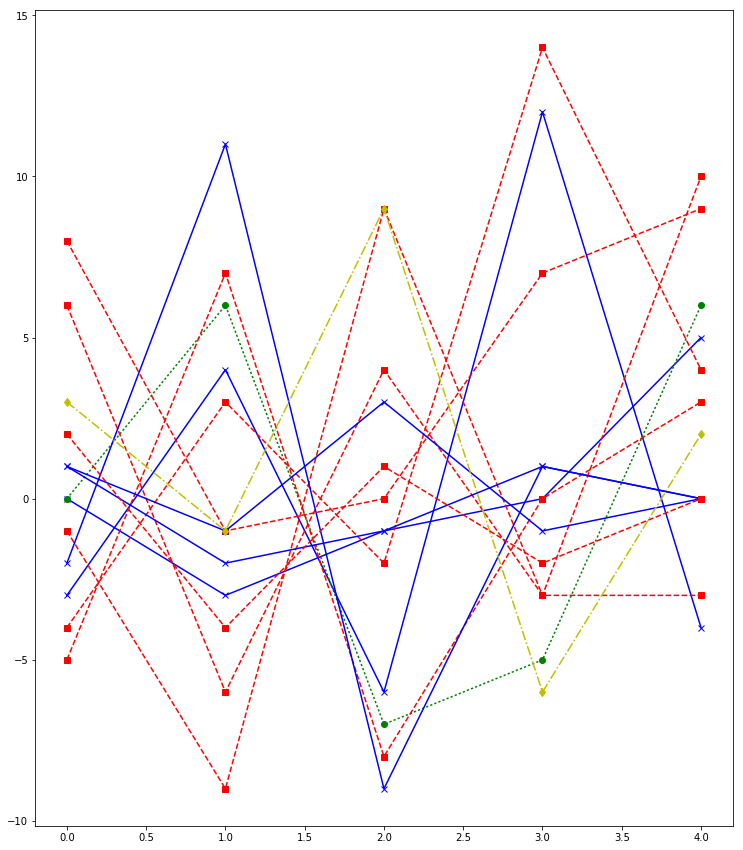

Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black


In [124]:
colors = ['go:', 'rs--', 'bx-', 'yd-.', 'k*--']
legend = ['Under 50', '50<=x<60', '60<=x<70', '70<=x<75', '75+']
labels = []
vectors = []
for key in differenceControlFemales:
    female = differenceControlFemales[key]
    if female['age'] < 50:
        labels.append(0)
    elif female['age'] < 60:
        labels.append(1)
    elif female['age'] < 70:
        labels.append(2)
    elif female['age'] < 75:
        labels.append(3)
    else:
        labels.append(4)
    vectors.append(female['vector'])
usefulFunctions.createLinePlotsOnSamePlot(vectors, labels, colors)
print "Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black"

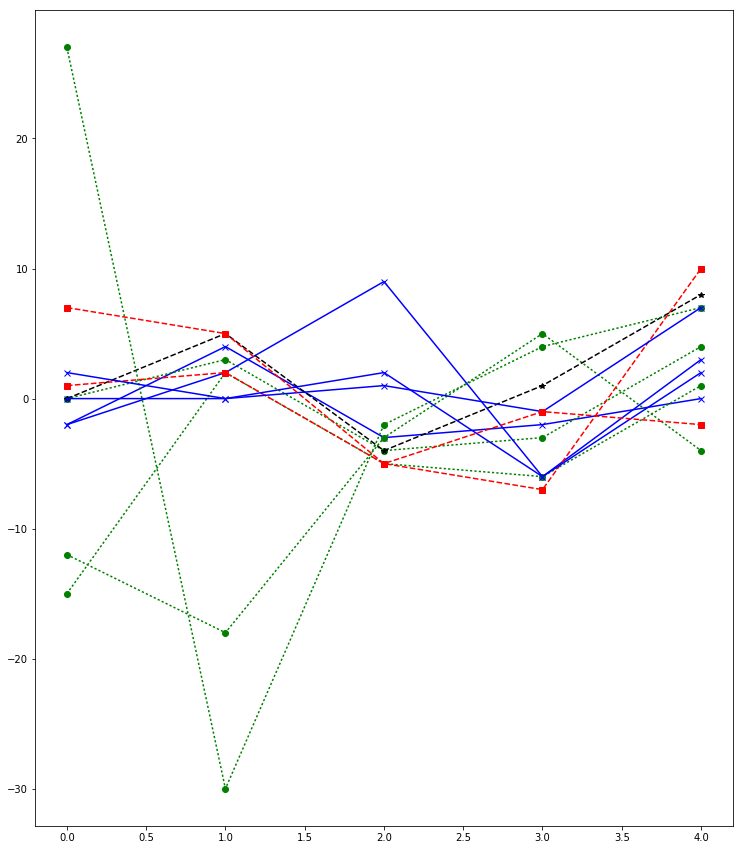

Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black


In [122]:
colors = ['go:', 'rs--', 'bx-', 'yd-.', 'k*--']
legend = ['Under 50', '50<=x<60', '60<=x<70', '70<=x<75', '75+']
labels = []
vectors = []
for key in differenceSickFemales:
    female = differenceSickFemales[key]
    if female['age'] < 50:
        labels.append(0)
    elif female['age'] < 60:
        labels.append(1)
    elif female['age'] < 70:
        labels.append(2)
    elif female['age'] < 75:
        labels.append(3)
    else:
        labels.append(4)
    vectors.append(female['vector'])
usefulFunctions.createLinePlotsOnSamePlot(vectors, labels, colors)
print "Under 50 - green, 50<=x<60 - red, 60<=x<70 - blue, 70<=x<75 - yellow, 75+ - black"

In [74]:
young_control = {}
young_sick = {}
middle_1_control = {}
middle_1_sick = {}
middle_2_control = {}
middle_2_sick = {}
middle_3_control = {}
middle_3_sick = {}
old_control = {}
old_sick = {}
for key in control:
    age = control[key]['age'] 
    if age < 50:
        young_control[key] = control[key]
    elif age < 60:
        middle_1_control[key] = control[key]
    elif age < 70:
        middle_2_control[key] = control[key]
    elif age <75:
        middle_3_control[key] = control[key]
    else:
        old_control[key] = control[key]

for key in sick:
    age = sick[key]['age'] 
    if age < 50:
        young_sick[key] = sick[key]
    elif age < 60:
        middle_1_sick[key] = sick[key]
    elif age < 70:
        middle_2_sick[key] = sick[key]
    elif age <75:
        middle_3_sick[key] = sick[key]
    else:
        old_sick[key] = sick[key]

young_control = getFullValuesOnly(young_control, True)
young_sick = getFullValuesOnly(young_sick, True)
middle_1_control = getFullValuesOnly(middle_1_control, True)
middle_1_sick = getFullValuesOnly(middle_1_sick, True)
middle_2_control = getFullValuesOnly(middle_2_control, True)
middle_2_sick = getFullValuesOnly(middle_2_sick, True)
middle_3_control = getFullValuesOnly(middle_3_control, True)
middle_3_sick = getFullValuesOnly(middle_3_sick, True)
old_control = getFullValuesOnly(old_control, True)
old_sick = getFullValuesOnly(old_sick, True)

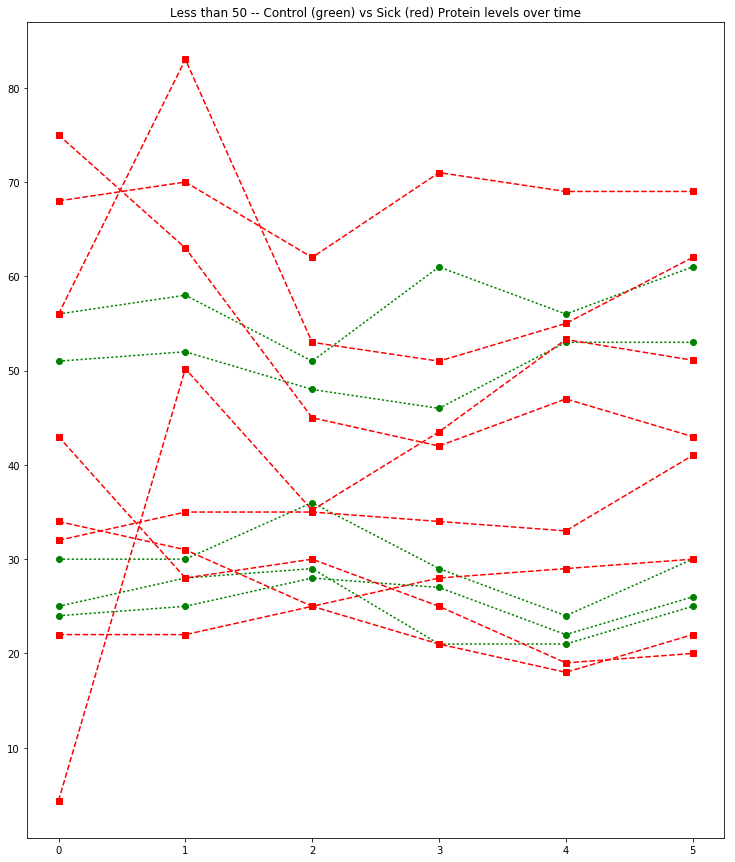

In [79]:
labels = []
allV = []
for key in young_control:
    labels.append(0)
    allV.append(young_control[key]['vector'])
for key in young_sick:
    labels.append(1)
    allV.append(young_sick[key]['vector'])

colors = ['go:', 'rs--']
title = "Less than 50 -- Control (green) vs Sick (red) Protein levels over time"
usefulFunctions.createLinePlotsOnSamePlot(allV, labels, colors, title)

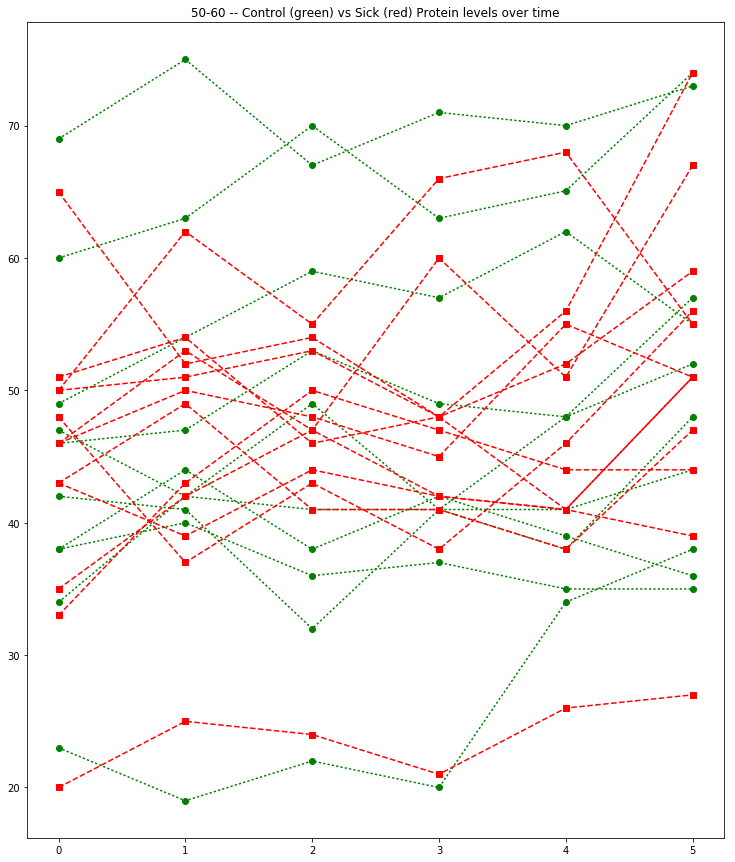

In [82]:
labels = []
allV = []
for key in middle_1_control:
    labels.append(0)
    allV.append(middle_1_control[key]['vector'])
for key in middle_1_sick:
    labels.append(1)
    allV.append(middle_1_sick[key]['vector'])

colors = ['go:', 'rs--']
title = "50-60 -- Control (green) vs Sick (red) Protein levels over time"
usefulFunctions.createLinePlotsOnSamePlot(allV, labels, colors, title)

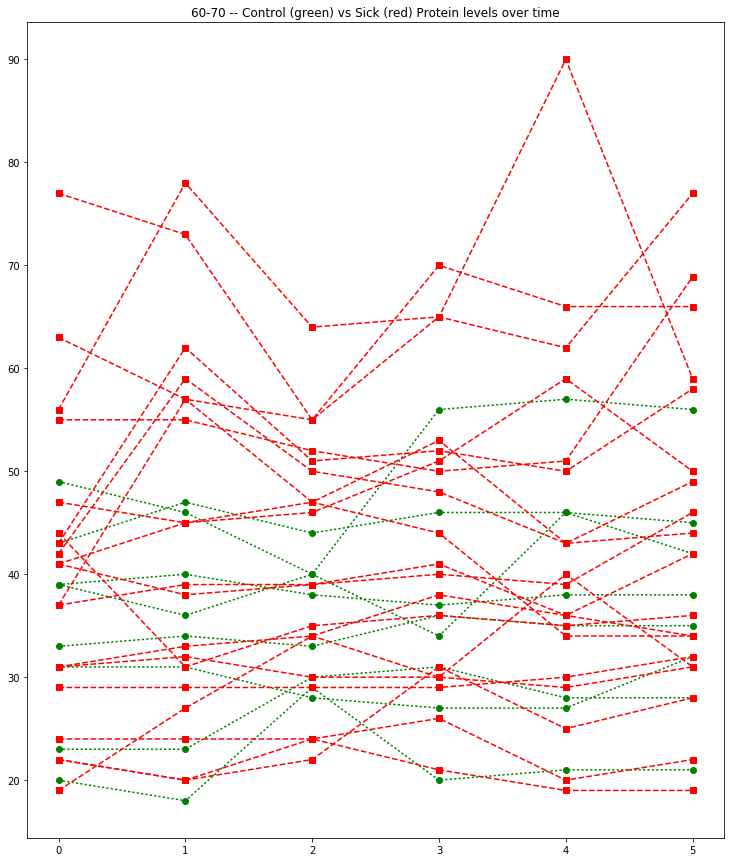

In [106]:
labels = []
allV = []
for key in middle_2_control:
    labels.append(0)
    allV.append(middle_2_control[key]['vector'])
for key in middle_2_sick:
    labels.append(1)
    allV.append(middle_2_sick[key]['vector'])

colors = ['go:', 'rs--']
title = "60-70 -- Control (green) vs Sick (red) Protein levels over time"
usefulFunctions.createLinePlotsOnSamePlot(allV, labels, colors, title)